## Signal and Noise Waveforms Classification 

In [1]:
# import models
from keras.layers import *
from keras.models import Sequential, Model, load_model
from keras import optimizers, losses
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,LearningRateScheduler, CSVLogger
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay 
from scipy import fftpack
from keras.optimizers import Adam
import time
import numpy as np
import h5py
import sys
import os
import seaborn as sns
sys.path.insert(1, '../')
from demos.utils import *

# set random seed
seed = 202414
np.random.seed(seed)
tf.random.set_seed(seed)

# run with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

# check the existing of folders
if os.path.isdir('../figs') == False:  
	os.makedirs('../figs',exist_ok=True)

2024-11-15 22:12:46.266422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-15 22:12:46.266452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-15 22:12:46.267578: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 22:12:46.272784: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-15 22:12:46.788494: W tensorflow/compiler/tf2

2 Physical GPUs, 1 Logical GPU


2024-11-15 22:12:48.079717: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-15 22:12:48.079945: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-15 22:12:48.112610: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Define data path

In [2]:
signal_id_path = '../data/txed_signal_id.npy'
noise_id_path = '../data/txed_noise_id.npy'
TXED_path = os.getenv('HOME')+'/Yang/Data/Earthquake_data/TXED/TXED_0913.h5'
model_path = '../model/EQ_classification_best_model.h5'
fig_path = '../figs/'

## Load testing datasets from TXED

In [3]:
# For the TXED data, please download from the following link:
# https://drive.google.com/drive/folders/1WXVB8ytNB4bOaZ97oq6OmMRyAEg95trp?usp=sharing  (~70 GB)
# After downloading the data, please put the TXED to '../data/'

# load the ID of signal and noise waveforms
signal_id_all = np.load(signal_id_path, 'r')
signal_id = signal_id_all[:10000]

noise_id_all = np.load(noise_id_path, 'r')
noise_id = noise_id_all[:10000]

f_txed = h5py.File(TXED_path, 'r')


# read signal waveforms from IDs
signal_list = []
for key in signal_id:
    if key in f_txed:   
        dataset = f_txed.get(key)
        signal_list.append(dataset['data'])  
signal_waveforms = np.array(signal_list)

# read noise waveforms from IDs
noise_list = []
for key in noise_id:
    if key in f_txed:   
        dataset = f_txed.get(key)
        noise_list.append(dataset['data'])  
noise_waveforms = np.array(noise_list)

# build testing data
test_data = np.concatenate([signal_waveforms,noise_waveforms],axis=0)
print(signal_waveforms.shape, noise_waveforms.shape)

(10000, 6000, 3) (10000, 6000, 3)


## Build labels of signal and noise waveforms

In [4]:
# create labels
labels=np.ones([signal_waveforms.shape[0],1])
labeln=np.zeros([noise_waveforms.shape[0],1])

# concatenate two matrix
label=np.concatenate([labels,labeln],axis=0)

# to categorical 
label = to_categorical(label)

## Load model and predict

In [5]:
# load model
EQ_model = load_model(f'{model_path}')

# predict 
pre_data = EQ_model.predict(test_data)

# applied threshold to the predicts
thre_pred_data = class_thres(pre_data, alpha=0.5)

# evaluate the predictions
test_labels = label[:,0]
predicted_classes = thre_pred_data[:,0]

accuracy = accuracy_score(test_labels,predicted_classes)
precision = precision_score(test_labels,predicted_classes)
recall = recall_score(test_labels,predicted_classes)
F1_score1 = 2*precision*recall/(precision+recall)

print(f'The accuracy of the model is {accuracy*100:.2f}%,\
the precision is {precision*100:.2f}%, the recall is {recall*100:.2f}%,\
and the F1 scorei is {F1_score1*100:.2f}%.')

2024-11-15 22:12:55.855278: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


625/625 [==============================] - 9s 12ms/step
The accuracy of the model is 99.79%,the precision is 99.69%, the recall is 99.89%,and the F1 scorei is 99.79%.


## Visualize the result using confusion matrix

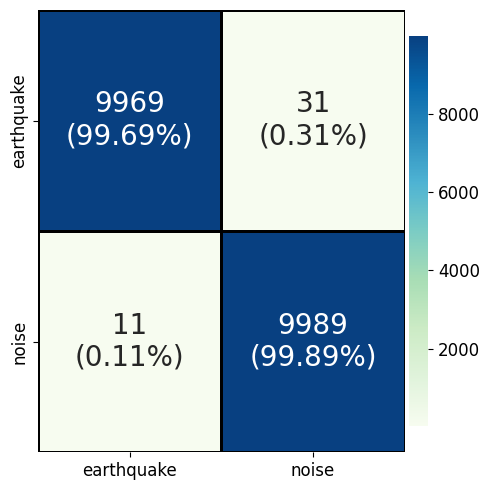

In [10]:
# calculate the confusion matrix
C = confusion_matrix(test_labels, predicted_classes)


custom_labels = ['earthquake', 'noise']

# Create custom annotations with both counts and percentages
confusion_m = C.astype('float') / C.sum(axis=1)[:, np.newaxis]
annotations = np.empty_like(C).astype(str)
n_classes = C.shape[0]
for i in range(n_classes):
    for j in range(n_classes):
        annotations[i, j] = f'{C[i, j]}\n({confusion_m[i, j] * 100:.2f}%)'

# Plot the heatmap with the counts (C) as values for the colorbar
plt.figure(figsize=(5, 5))
ax = sns.heatmap(C, annot=annotations, fmt='', cmap="GnBu", annot_kws={"fontsize": 20}, linewidths=1, linecolor='black', 
                 cbar_kws={"shrink": 1, 'aspect': 20, 'fraction': 0.05, 'pad': 0.01})

# Set x-axis and y-axis labels
ax.set_xticklabels(custom_labels, fontsize=12)
ax.set_yticklabels(custom_labels, fontsize=12, rotation=90)

# Set x and y labels
# plt.xlabel('Prediction', fontsize=12, fontweight='bold')
# plt.ylabel('Ground truth', fontsize=12, fontweight='bold')

# Customize the colorbar to show the number of true predictions
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

# Adjust layout
plt.tight_layout()

plt.savefig(f'{fig_path}EQ_classification_result.png')
plt.show()